# Gerekli kütüphanelerin import edilmesi:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler #Standartlaştırma yapabilmek için
from sklearn.model_selection import train_test_split, GridSearchCV # GridSearchCV, KNN best parametreleri bulmak için
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis, LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

#warningleri kapatmak için
import warnings 
warnings.filterwarnings("ignore")

!pip install catboost
!pip install lightgbm
!pip install xgboost

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Veri seti yükleme

In [ ]:
data = pd.read_csv("/content/data.csv")

In [ ]:
data.drop(['Unnamed: 32', 'id'], inplace = True, axis =1)
data = data.rename(columns = {"diagnosis":"target"})
data["target"] = [1 if i.strip() == "M" else 0 for i in data.target]

In [ ]:
print(data.target.value_counts())

0    357
1    212
Name: target, dtype: int64


In [ ]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
  
check_df(data)


##################### Shape #####################
(569, 31)
##################### Types #####################
target                       int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_wors

Standartizasyon gerekiyor
Eksik veri yok

# EDA

Correlation

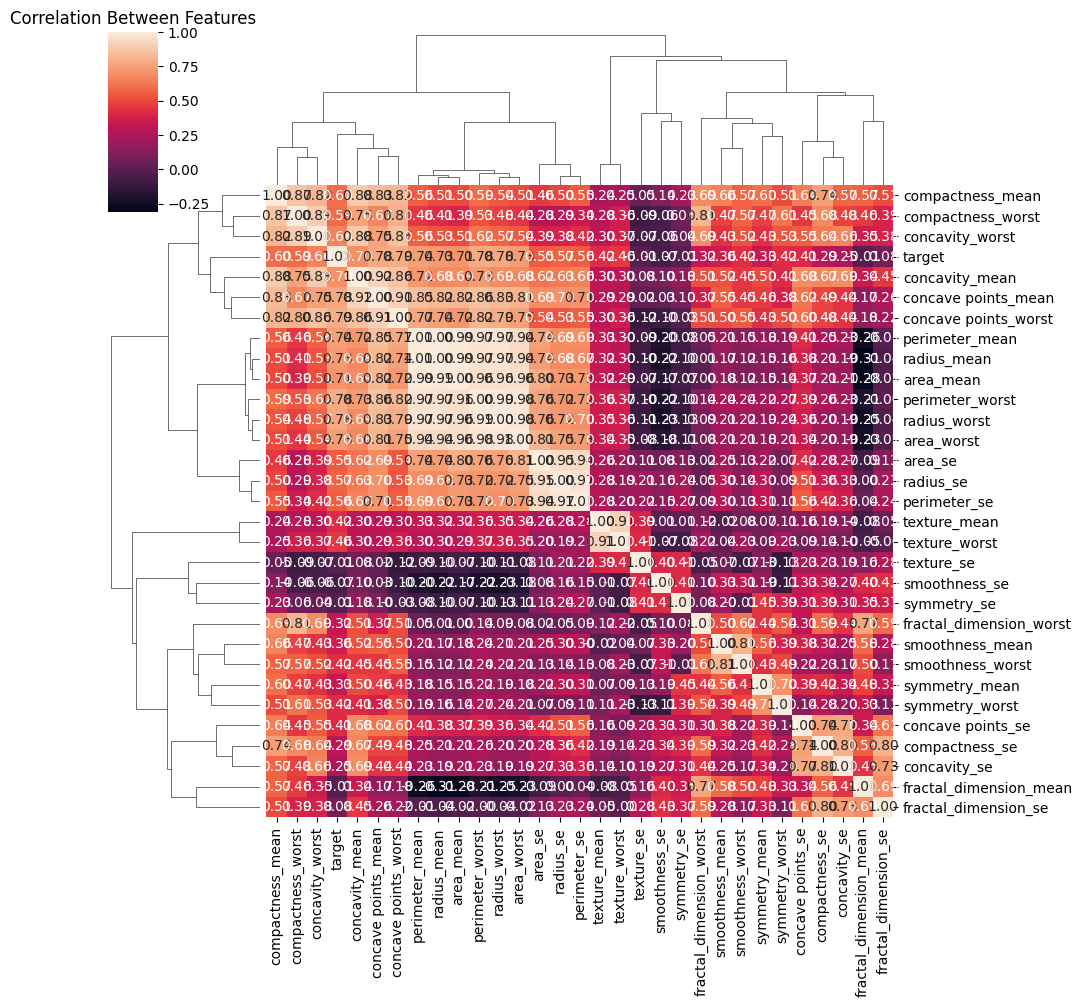

In [ ]:
corr_matrix = data.corr()
sns.clustermap(corr_matrix, annot = True, fmt ='.2f')
plt.title("Correlation Between Features")
plt.show()

Birbirleri arasında yüksek korelasyona shaip iki değişkenin kuracağım modele katkısı neredeyse aynıdır. 

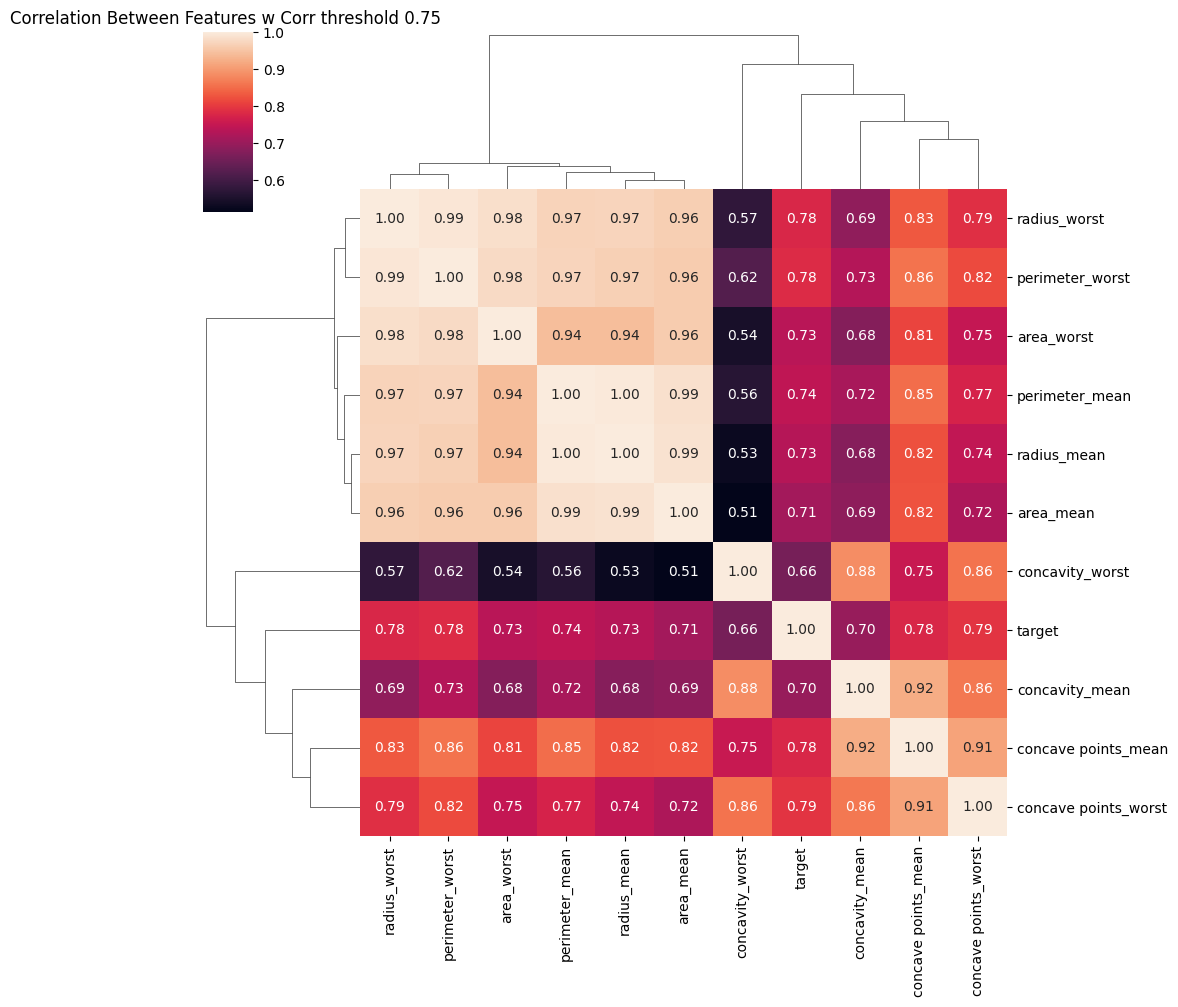

In [ ]:
threshold = 0.65
filter = np.abs(corr_matrix["target"]) > threshold
corr_features = corr_matrix.columns[filter].tolist()
sns.clustermap(data[corr_features].corr(), annot = True, fmt ='.2f')
plt.title("Correlation Between Features w Corr threshold 0.75 ")
plt.show()

Box Plot

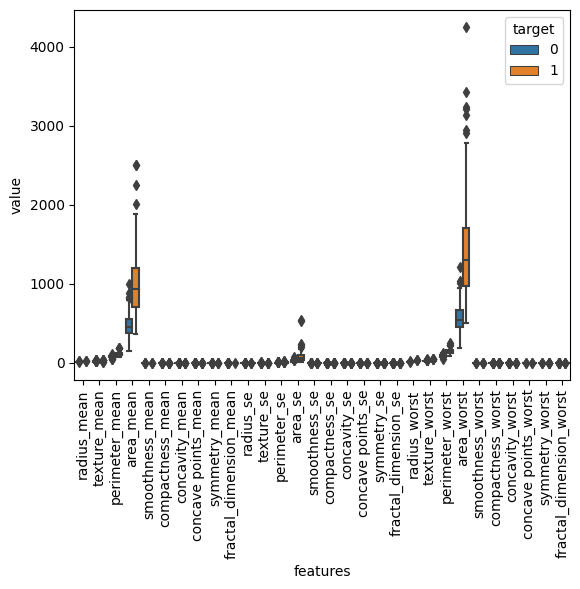

In [ ]:
data_melted = pd.melt(data, id_vars = "target",
                      var_name = "features",
                      value_name = "value")

plt.figure()
sns.boxplot(x = "features", y = "value", hue = "target" , data = data_melted)
plt.xticks(rotation = 90)
plt.show() #Standartize edilmeli.

Pair plot

In [ ]:
#sns.pairplot(data[corr_features], diag_kind = "kde", markers = "+", hue ="target")
#plt.show() #Skewness

# Outlier Detection

Density based ODS --> Local Outlier Factor  yöntemini kullanacağız

In [ ]:
y = data.target
x = data.drop(["target"], axis=1)
columns = x.columns.tolist()

In [ ]:
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(x)
X_score = clf.negative_outlier_factor_

In [ ]:
y_pred #-1 olanlar outlier

array([ 1,  1,  1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1

In [ ]:
outlier_score = pd.DataFrame()
outlier_score["score"] = X_score
outlier_score

,score
0,-1.422440
1,-1.066782
2,-0.978948
3,-1.596933
4,-1.069936
...,...
564,-1.330082
565,-0.997906
566,-0.997441
567,-0.993730


In [ ]:
# -2.5'luk bir threshold belirledik.
threshold = -2.5
filter = outlier_score["score"] < threshold
outlier_index = outlier_score[filter].index.tolist()

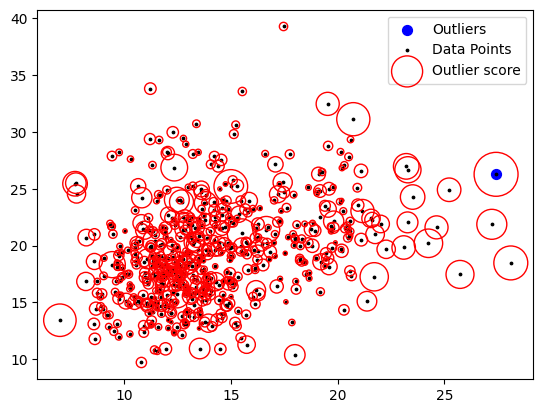

In [ ]:
plt.figure()
plt.scatter(x.iloc[outlier_index, 0], x.iloc[outlier_index, 1], color = "blue", s=50, label = "Outliers")
plt.scatter(x.iloc[:,0], x.iloc[:,1], color = "k", s=3, label = "Data Points")

radius = (X_score.max() - X_score)/(X_score.max() - X_score.min())
outlier_score["radius"] = radius
plt.scatter(x.iloc[:,0], x.iloc[:,1], s = 1000*radius, edgecolors ="r", facecolors="none", label = "Outlier score")
plt.legend()
plt.show()

In [ ]:
#drop outliers
x = x.drop(outlier_index)
y = y.drop(outlier_index).values

# Train Test split


In [ ]:
test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = test_size, random_state=42)

# Standardization

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) #X traine göre eğitilmiş scalerımı X_test üzerinde uyguluyoruz. Böylece X_testide scale etmiş oluyoruz.

In [ ]:
X_train_df = pd.DataFrame(X_train, columns = columns)

In [ ]:
X_train_df["target"] = Y_train

In [ ]:
X_train_df_describe = X_train_df.describe()

Box Plot

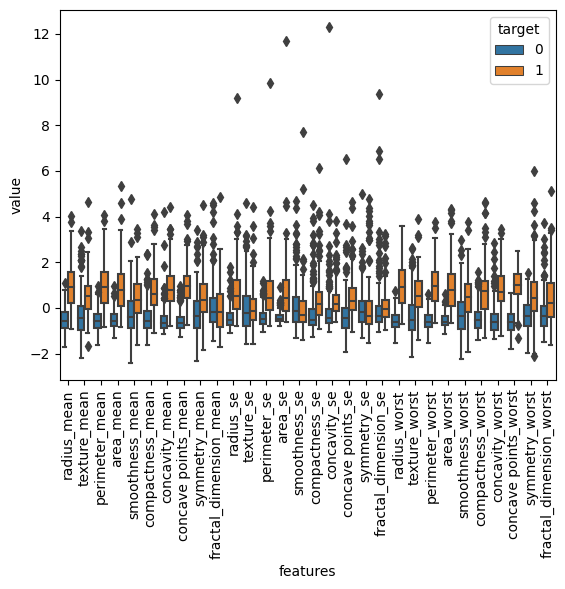

In [ ]:
data_melted = pd.melt(X_train_df, id_vars = "target",
                      var_name = "features",
                      value_name = "value")

plt.figure()
sns.boxplot(x = "features", y = "value", hue = "target" , data = data_melted)
plt.xticks(rotation = 90)
plt.show() #Standartize edilmeli.

Pair plot

In [ ]:
# sns.pairplot(X_train_df[corr_features], diag_kind = "kde", markers = "+",hue = "target")
# plt.show()


#Model

Model seçimi

In [ ]:
def classification_models(model):
    y_pred=model.fit(X_train,Y_train).predict(X_test)
    accuracy=accuracy_score(y_pred,Y_test)
    roc_score=roc_auc_score(y_pred,model.predict_proba(X_test)[:,1])
    f1=f1_score(y_pred,Y_test)
    precision=precision_score(y_pred,Y_test)
    recall=recall_score(y_pred,Y_test)
    
    results=pd.DataFrame({"Values":[accuracy,roc_score,f1,precision,recall],
                         "Metrics":["Accuracy","ROC-AUC","F1","Precision","Recall"]})
    print(model)
    print("------------")
    print(results)

In [ ]:
my_models= [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    LGBMClassifier()
    ]

for model in my_models:
    classification_models(model)

LogisticRegression()
------------
     Values    Metrics
0  0.982456   Accuracy
1  1.000000    ROC-AUC
2  0.975610         F1
3  0.967742  Precision
4  0.983607     Recall
KNeighborsClassifier()
------------
     Values    Metrics
0  0.959064   Accuracy
1  1.000000    ROC-AUC
2  0.944000         F1
3  0.951613  Precision
4  0.936508     Recall
DecisionTreeClassifier()
------------
     Values    Metrics
0  0.947368   Accuracy
1  1.000000    ROC-AUC
2  0.926829         F1
3  0.919355  Precision
4  0.934426     Recall
RandomForestClassifier()
------------
     Values    Metrics
0  0.947368   Accuracy
1  1.000000    ROC-AUC
2  0.925620         F1
3  0.903226  Precision
4  0.949153     Recall
GradientBoostingClassifier()
------------
     Values    Metrics
0  0.976608   Accuracy
1  1.000000    ROC-AUC
2  0.967742         F1
3  0.967742  Precision
4  0.967742     Recall
LGBMClassifier()
------------
     Values    Metrics
0  0.964912   Accuracy
1  1.000000    ROC-AUC
2  0.950820         F1


Logistic Regression modelini seçiyoruz.

In [ ]:
LR =  LogisticRegression(random_state = 42)
LR_train =  LR.fit(X_train,Y_train)


In [ ]:
print('Training Score: ', LR.score(X_train, Y_train))
print('Testing Score: ', LR.score(X_test, Y_test))

Training Score:  0.9899244332493703
Testing Score:  0.9824561403508771


In [ ]:
# y pred
y_pred = LR_train.predict(X_test)
y_pred_train = LR_train.predict(X_train)


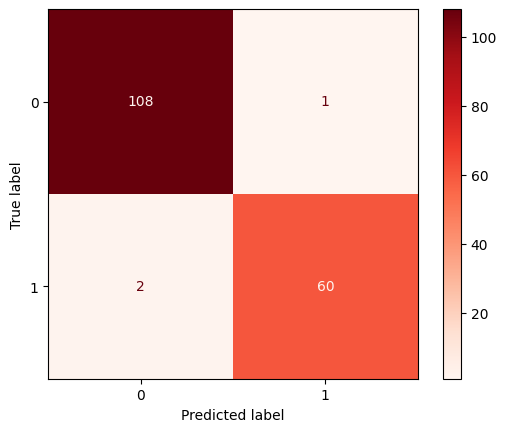

In [ ]:
cm = confusion_matrix(Y_test, y_pred)
matrix = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
matrix.plot(cmap = 'Reds')

In [ ]:
# Classification Report
print(classification_report(Y_test, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       109
           1       0.98      0.97      0.98        62

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

